In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_new
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


In [2]:
data_path = str(Path('/data/cresswellclayec/Pfam-A.full'))


pfam_id = 'PF00023'
pfam_id = 'PF00011'
pfam_id = 'PF14525'
pfam_id = 'PF03496'
pfam_id = 'PF03678'
pfam_id = 'PF00186'


n_jobs = 6
print('Finding MF contacts for %s', pfam_id)

create_new = True
printing = True
removing_cols = True


# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf' % DCA_ER_dir
msa_npy_file = '%s/%s/msa.npy' % (str(data_path), pfam_id)
msa_fa_file  = '%s/%s/msa.fa' %  (str(data_path), pfam_id)
pdb_ref_file = '%s/%s/pdb_refs.npy' %  (str(data_path), pfam_id)

out_dir = '%s/protein_data/di/' % biowulf_dir
processed_data_dir = "%s/protein_data/data_processing_output" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir


Finding MF contacts for %s PF00186


In [3]:
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)


try:
    # delete 'b' in front of letters (python 2 --> python 3)
    pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


    # Print number of pdb structures in Protein ID folder
    npdb = pdb.shape[0]
    print('number of pdb structures:',npdb)

    # Create pandas dataframe for protein structure
    pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                     'pdb_id','chain','pdb_start','pdb_end'])
    print(pdb_df.head())
    pdb_reference_ids = np.unique(pdb_df['pdb_id'].to_numpy())
    print('PDB reference IDs:\n', pdb_reference_ids)
    pdb_ref_ipdb = 0
    print('seq:',int(pdb[pdb_ref_ipdb,1]))



except(IndexError):
    print('Loaded pdb: ', pdb)
    print('\n\nEMPTY PDB REFERENCE!!!\n\n')
    pdb_reference_ids = None





number of pdb structures: 372
        PF seq            id uniprot_start uniprot_end pdb_id chain pdb_start  \
0  PF00186  69  Q5KZ26_GEOKA             1         160   1ZDR     B         1   
1  PF00186  69  Q5KZ26_GEOKA             1         160   1ZDR     A         1   
2  PF00186  83  Q81R22_BACAN             2         160   3JWK     B         2   
3  PF00186  83  Q81R22_BACAN             2         160   3S9U     B         2   
4  PF00186  83  Q81R22_BACAN             2         160   3FL9     H         2   

  pdb_end  
0     160  
1     160  
2     160  
3     160  
4     160  
PDB reference IDs:
 ['1BOZ' '1CZ3' '1D1G' '1DDR' '1DDS' '1DF7' '1DG5' '1DG7' '1DG8' '1DHI'
 '1DHJ' '1DLR' '1DLS' '1DR1' '1DR2' '1DR3' '1DR4' '1DR5' '1DR6' '1DR7'
 '1DRA' '1DRB' '1DRE' '1DRF' '1DRH' '1DYH' '1DYI' '1DYJ' '1HFP' '1HFQ'
 '1HFR' '1JOL' '1JOM' '1JUV' '1KMS' '1KMV' '1MVS' '1MVT' '1OHJ' '1OHK'
 '1PD8' '1PD9' '1PDB' '1RA1' '1RA2' '1RA3' '1RA8' '1RA9' '1RB2' '1RB3'
 '1RC4' '1RD7' '1RE7' '1RF7' '1RG7' 

In [4]:
s0, curated_cols, s_index, tpdb, pdb_select \
= data_processing_new(data_path, pfam_id, index_pdb=0,gap_seqs=0.2, gap_cols=0.2, prob_low=0.004,
                        conserved_cols=0.9, printing=True, out_dir=processed_data_dir, pdb_dir=pdb_dir,  letter_format=False,
                        remove_cols=removing_cols, create_new=create_new)


pdb_chain, ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range, poly_seq, pp_ca_coords_curated, pp_ca_coords_full_range \
= tools.contact_map_new(pdb_id=pdb_select['PDB ID'][:4], pdb_range=[pdb_select['Subject Beg'], pdb_select['Subject End']], \
                  removed_cols=curated_cols, queried_seq=pdb_select['Subject Aligned Seq'],  pdb_out_dir=pdb_dir)



Original Sequence length:  918
#

--------------------- Find Matching PDB Strucutre for MSA ----#
looking for pdb_references in /data/cresswellclayec/DCA_ER/biowulf/protein_data/pdb_data/ 
Raw-Query PDB dataframe gives 7714 matches... 

Sorted PDB matches (102 matches): 
       MSA Index  PDB ID  Score  Identity        E-value  Bitscore  \
6896       6896  3INV_1    1.0     1.000  7.540000e-138       432   
4761       4761  3CL9_1    1.0     1.000  1.417000e-137       431   
973         973  3INV_1    1.0     0.956  1.710000e-130       411   
5557       5557  1DR7_1    1.0     1.000  2.411000e-120       380   
250         250  3NXT_1    1.0     1.000  3.306000e-120       379   

      Alignment Length  Mismatches  Gaps Opened  Query Beg  Query End  \
6896               210           0            0          1        210   
4761               210           0            0          1        210   
973                208           9            0          1        208   
5557               1

In [5]:
from inference_dca import direct_info_dca
print('Final MSA shape before MF calculation: ', s0.shape)
seq_wt_file = None
seq_wt_file = '%s/seq_weight_%s.npy' % (processed_data_dir, pfam_id)


mf_di, fi, fij, c, cinv, w, w2d, fi_pydca, fij_pydca, c_pydca, c_inv_pydca, \
w_pydca, w2d_pydcak, di_pydca, ma_inv,seq_ints\
= direct_info_dca(s0, seq_wt_outfile=seq_wt_file)


Final MSA shape before MF calculation:  (5798, 138)
(5798, 138)
ma_inv (sequences weight shape:  (5798,)
tais meff = 4158.949543
meff for our MF =  4158.94954289443
(138, 21)
(138, 21)
(9453, 20, 20)
2760
PYDCA's compute_singel_site_freqs: 2 changes
m_eff for pydca calculation:  4158.94954289443


In [6]:

print(c_pydca[0])
print(c[0])
diff = c_pydca - c
print('\n\ndifference between correlation matrixces: ', diff)
print('\nmax element of difference matrix: %f' % max(map(max, diff)))
print('FrobeniusNorm of difference between c_pydca and c: ', np.linalg.norm(diff))


[ 0.02324263 -0.00056689 -0.00056689 ... -0.00038031  0.00056689
  0.00056689]
[ 0.02324263 -0.00056689 -0.00056689 ... -0.00038031  0.00056689
  0.00056689]


difference between correlation matrixces:  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
   0.00000000e+00  0.00000000e+00]
 ...
 [-2.16840434e-19 -2.16840434e-19 -2.16840434e-19 ...  6.93889390e-18
  -2.16840434e-19 -2.16840434e-19]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
   0.00000000e+00  0.00000000e+00]]

max element of difference matrix: 0.000000
FrobeniusNorm of difference between c_pydca and c:  4.28545243406523e-14


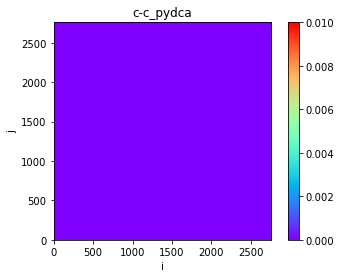

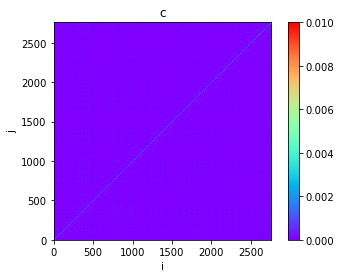

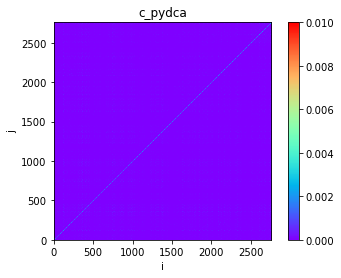

In [7]:
plt.title('c-c_pydca')
plt.imshow(diff,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.figure()
plt.title('c')
plt.imshow(c,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.figure()
plt.title('c_pydca')
plt.imshow(c_pydca,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
